In [63]:

from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
import datasets
import torch
from datasets import Dataset, load_dataset, Sequence, ClassLabel, Features, Value
import evaluate
from preprocessing import preprocessing, preprocessing_2, preprocessing_3, Sentence
from transformers import DataCollatorForTokenClassification
import numpy as np
import random
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Preprocessing
First, we will define some paths and constant variables.
+ `DATA_NAME`: The name of the file to use for training
+ `MODE`: It can either be `train` or `test` depending on wether a model already exists or not
+ `PER_DS`: It is the percentage of the dataset that is sampled for training

In [64]:
TRAIN_FILE_NAME = 'en_ewt-up-train.conllu'
TEST_FILE_NAME = 'en_ewt-up-test.conllu'
DEV_FILE_NAME = 'en_ewt-up-dev.conllu'
model_name = 'distilbert-base-uncased'
MODEL_NAME = 'bert_baseline_model_train'
MODE='train'
PER_DS = 0.2

## 1.1 Calling external libraries
We will call the preprocessing library with the `DATA_NAME` file that we used earlier. It should be located in the `data/raw` path for it to be recongnized. It will go over the the CONLL-U file and create a dataframe with it as well as organize the argument label and repeat the tokes as many times at there are predictes in a given sentence. Consequently, if there are 3 predicates in a sentence, there will be 3 rows with the same token per sentence with a different target label depending on if they are part of the argument or not and which argument they are for that predicate.

Also, during preprocessing the arguments with a `C-` or `R-` prefix will be merged with thei respective suffix. We do this as they are *continuous* or *reference* arguments. Meaning that given the interpretation, we could label them to same. We have decided to do this as our motivation lies in identified the types of clauses rather than the specific differentiation if it is a reference or a continuation.

Additionally, we will label predicates as `O`, not an argument.

In [88]:
filename = TRAIN_FILE_NAME if MODE == 'train' else TEST_FILE_NAME if MODE == 'test' else DEV_FILE_NAME
df, label_list = preprocessing_3(filename, force=True)

In [89]:
df

,id,position,word,lemma,pos_u,pos_tag,d_tag,head,dep_tag,is_pred,pred,label,sentence_id
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Al, -, Zaman, :, American, forces, killed, Sh...","[Al, -, Zaman, :, american, force, kill, Shaik...","[PROPN, PUNCT, PROPN, PUNCT, ADJ, NOUN, VERB, ...","[NNP, HYPH, NNP, :, JJ, NNS, VBD, NNP, NNP, NN...","[Number=Sing, _, Number=Sing, _, Degree=Pos, N...","[0, 1, 1, 1, 6, 7, 1, 7, 8, 8, 8, 8, 8, 15, 8,...","[root, punct, flat, punct, amod, nsubj, parata...","[False, False, False, False, False, False, Tru...","[killed, killed, killed, killed, killed, kille...","[_, _, _, _, _, ARG0, V, ARG1, _, _, _, _, _, ...",0
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[, This, killing, of, a, respected, cleric, w...","[[, this, killing, of, a, respected, cleric, w...","[PUNCT, DET, NOUN, ADP, DET, ADJ, NOUN, AUX, A...","[-LRB-, DT, NN, IN, DT, JJ, NN, MD, VB, VBG, P...","[_, Number=Sing|PronType=Dem, Number=Sing, _, ...","[10, 3, 10, 7, 7, 7, 3, 10, 10, 0, 10, 10, 14,...","[punct, det, nsubj, case, det, amod, nmod, aux...","[False, False, True, False, False, False, Fals...","[killing, killing, killing, killing, killing, ...","[_, _, V, _, _, _, ARG1, _, _, _, _, _, _, _, ...",1
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[, This, killing, of, a, respected, cleric, w...","[[, this, killing, of, a, respected, cleric, w...","[PUNCT, DET, NOUN, ADP, DET, ADJ, NOUN, AUX, A...","[-LRB-, DT, NN, IN, DT, JJ, NN, MD, VB, VBG, P...","[_, Number=Sing|PronType=Dem, Number=Sing, _, ...","[10, 3, 10, 7, 7, 7, 3, 10, 10, 0, 10, 10, 14,...","[punct, det, nsubj, case, det, amod, nmod, aux...","[False, False, True, False, False, False, Fals...","[be, be, be, be, be, be, be, be, be, be, be, b...","[_, _, _, _, _, _, _, _, V, _, _, _, _, _, _, ...",1
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[, This, killing, of, a, respected, cleric, w...","[[, this, killing, of, a, respected, cleric, w...","[PUNCT, DET, NOUN, ADP, DET, ADJ, NOUN, AUX, A...","[-LRB-, DT, NN, IN, DT, JJ, NN, MD, VB, VBG, P...","[_, Number=Sing|PronType=Dem, Number=Sing, _, ...","[10, 3, 10, 7, 7, 7, 3, 10, 10, 0, 10, 10, 14,...","[punct, det, nsubj, case, det, amod, nmod, aux...","[False, False, True, False, False, False, Fals...","[causing, causing, causing, causing, causing, ...","[_, _, ARG0, _, _, _, _, ARGM-MOD, _, V, ARGM-...",1
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[, This, killing, of, a, respected, cleric, w...","[[, this, killing, of, a, respected, cleric, w...","[PUNCT, DET, NOUN, ADP, DET, ADJ, NOUN, AUX, A...","[-LRB-, DT, NN, IN, DT, JJ, NN, MD, VB, VBG, P...","[_, Number=Sing|PronType=Dem, Number=Sing, _, ...","[10, 3, 10, 7, 7, 7, 3, 10, 10, 0, 10, 10, 14,...","[punct, det, nsubj, case, det, amod, nmod, aux...","[False, False, True, False, False, False, Fals...","[come, come, come, come, come, come, come, com...","[_, _, _, _, _, _, _, _, _, _, _, _, _, ARG1, ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40477,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[I, will, never, return, there, again, (, and,...","[I, will, never, return, there, again, (, and,...","[PRON, AUX, ADV, VERB, ADV, ADV, PUNCT, CCONJ,...","[PRP, MD, RB, VB, RB, RB, -LRB-, CC, RB, VBP, ...","[Case=Nom|Number=Sing|Person=1|PronType=Prs, V...","[4, 4, 4, 0, 4, 4, 4, 10, 10, 4, 13, 13, 10, 1...","[nsubj, aux, advmod, root, advmod, advmod, pun...","[False, False, False, True, False, False, Fals...","[return, return, return, return, return, retur...","[ARG1, ARGM-MOD, ARGM-NEG, V, ARG4, ARGM-TMP, ...",12542
40478,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0, 1, 2, 3, 4, 5, 6,

In [90]:
df.columns

Index(['id', 'position', 'word', 'lemma', 'pos_u', 'pos_tag', 'd_tag', 'head',
       'dep_tag', 'is_pred', 'pred', 'label', 'sentence_id'],
      dtype='object')

## 1.2 Dataset construction
The `huggingface` set of libraries provides a very good wrapper for processing datasets. For that reason, we will transform our data to that format by giving the types of the `features` and then passing our raw data to it

In [98]:
features = Features({
    'id': Sequence(feature=Value('float32')),
    'position': Sequence(feature=Value('float32')),
    'word': Sequence(feature=Value('string')),
    'lemma': Sequence(feature=Value('string')),
    'pos_u': Sequence(feature=Value('string')),
    'pos_tag': Sequence(feature=Value('string')),
    'd_tag': Sequence(feature=Value('string')),
    'head': Sequence(feature=Value('string')),
    'dep_tag': Sequence(feature=Value('string')),
    'is_pred': Sequence(feature=Value('bool')),
    'pred': Sequence(feature=Value('string')),
    'label': Sequence(feature=ClassLabel(names=label_list)),
    'sentence_id': Value('int32'),

})

ds = Dataset.from_pandas(df[list(features.keys())], features=features)


# 1.4 Dataset filtering
Here we sample $k$ observations uniformly from the dataset, where $k=N*\alpha$ and $\alpha$ is `PER_DS` or the porcentage of the dataset we want to use for training. 

In [99]:
ds = ds.select(random.sample(range(len(ds)), int(len(ds)*PER_DS)))
len(ds)

8096

# 1.5 Tokenization 
To perform tokenization we use the BERT base tokenizer from the `distillbert-base-uncased` model, so that is the standard BERT implementation without separate tokens for word cases. 

In [100]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
SEP_TOKEN_ID = tokenizer.all_special_ids[tokenizer.all_special_tokens.index('[SEP]')]

# 1.5.1 Actual tokenization and alignment
Here we call a function that will return a dataset in terms of `input_ids` and `attention_masks`. It will construct the proposed input as `(Shi, P. and Lin, J., 2019)`, where we have `[CLS] sent [SEP] pred [SEP]`, giving the model the whole sentence and then the predicate at the end of the sentence. It will also construt the corresponding true labels on this, assigning the tokens to the true labels. Words we do not want to predict a label for are marked with an integer that is generally $-100$.

In [102]:
from utils import tokenize_and_align_labels
ex_sent_row = ds[0]
predicate = ex_sent_row['pred'][0]
ex_sent = ex_sent_row['word']

Now we are going to inspect how does our tokenization and alignment works. First, we check how the `predicate` is tokenized. First we take a look at the `predicate`. We pick the first one because according to our implementation it will contained a repeated list of predicates.

In [103]:
predicate

'go'

Now we are going to see how its tokenized

In [104]:
tok_predicate = tokenizer([predicate], is_split_into_words=True)
tok_predicate

{'input_ids': [101, 2175, 102], 'attention_mask': [1, 1, 1]}

Event though our predicate is only one word, the tokenization is returning different ids. Lets look closer.

In [105]:
tokenizer.convert_ids_to_tokens(tok_predicate['input_ids'])

['[CLS]', 'go', '[SEP]']

We see know that it has been encoded as 2 *special tokens* plus the actual word has been divided into 3 sub-tokens. Let's look  at what happens if we construct our input sentence by appending the `predicate` to the `sentence`. Also notice we will apply `truncation` and `padding`. Truncation will remove tokens after token $64$ and `padding` will ensure all the resulting tokenized sentences have the same length.

In [106]:
tok_whole = tokenizer(ex_sent, [predicate], padding='max_length', max_length=64, truncation=True, is_split_into_words=True)

We can see that the amount of tokens after *tokenization* has grown. (also because of the PAD token)

In [107]:
print(len(tok_whole['input_ids']), len(ex_sent) + 1)

64 17


Here we can see the sentence turned back into words.

In [108]:
tokenizer.convert_ids_to_tokens(tok_whole['input_ids'])

['[CLS]',
 'ken',
 'said',
 'to',
 'go',
 'ahead',
 'and',
 'e',
 '##qui',
 '##p',
 'it',
 'with',
 'what',
 'you',
 'think',
 'it',
 'should',
 'have',
 '.',
 '[SEP]',
 'go',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

We can see that `predicate` has been appended to the end corrently. Note that also `token_type_ids` will change and instead of containing just 0s will contain 1s for our next word. Notice the `[PAD]` token at the end.

Next, we will see how the labeling changes, since the output is also a number, we need to map our outputs to the appropriate labels. `word_ids` will return a list which has an index for each token and the word it respresents. If it is a *subtoken* it will be repeated and if its a special token it will be `None`.

In [109]:
len(tok_whole.word_ids())

64

To construct our labels, we only care about labeling the sentence that comes first so we need to construct a way to identify the first set of tokens and discard the rest. For this, we can tokenize the sentence again and just set all the other tokens to a value ignored by PyTorch $(-100)$

In [112]:
tok_sent_alone = tokenizer(ex_sent, is_split_into_words=True)
label_ids = []

for i, word_idx in enumerate(tok_whole.word_ids()):
    if word_idx is None:
        # If it is a special token do not add a label
        label_ids.append(-100)
    elif i >= len(tok_sent_alone['input_ids']):
        # If the token is part of the predicate do not add a label
        label_ids.append(-100)
    else: 
        # Set the label of the first token of each word
        label_ids.append(ex_sent_row['label'][word_idx])
label_names = ds.features['label'].feature.names
decoded_labels = [label_names[idx] if idx != -100 else '_' for idx in label_ids]
(len(decoded_labels), len(tok_whole['input_ids']))

(64, 64)

Now they have the same length and on a closer look we will see that it only contains labels for the sentence.

In [113]:
decoded_labels

['_',
 'ARG0',
 '_',
 '_',
 'V',
 'ARG2',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_',
 '_']

Now we apply a map to calculate that for every row in our `Dataset`

In [115]:
from utils import tokenize_and_align_labels
tokenized_datasets = ds.map(lambda x: tokenize_and_align_labels(tokenizer, x))

/Users/martincarrasco/miniconda3/envs/anlp/lib/python3.12/site-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Map:   0%|          | 0/8096 [00:00<?, ? examples/s]

Here we can look at the  labels of the first row in the dataset already tokenized

In [116]:
tokenized_datasets['labels'][0]

[-100,
 9,
 23,
 23,
 44,
 16,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 23,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100]

# 2 Baseline model training
Now we specify some general information about the model we are going to train and the hyper-parameters we will use.

+ `LR`: Learning rate for the weights (amount of adjustment to the gradients on update of weights)
+ `EPOCHS`: The full runs we do on the training data 
+ `WEIGHT_DECAY`: A normalization parameter applied to the weights each iteration
+ `BATCH_SIZE`: The amount of batches where to sum of gradients before performing an update. It can be though of like the **step-size**

In [117]:
task = 'SRL'
BATCH_SIZE = 32
LR =2e-5
EPOCHS = 1
WEIGHT_DECAY = 0.01

The `TrainerArgument` class will let of specify all this information as well as a model name to put our model on the Hub

In [118]:
from transformers import DataCollatorForTokenClassification


args = TrainingArguments(
    f"{model_name}-finetuned-{task}_a",
    evaluation_strategy = "epoch",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    push_to_hub=False,
)

model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_list))

data_collator = DataCollatorForTokenClassification(tokenizer)


Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 2.1 Model training
Now we actually get to training. We remove irrelevant columns from the dataset and pass all of our information to the actual trainer. Then we run the training and save the model

In [119]:
from utils import compute_metrics
td = tokenized_datasets.remove_columns(ds.column_names)
MODEL_NAME = 'bert_baseline_model_train_a'
trainer = Trainer(
    model,
    args,
    train_dataset=td,
    eval_dataset=td,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=lambda x: compute_metrics(x, label_list),
)


/Users/martincarrasco/miniconda3/envs/anlp/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [120]:
trainer.train()
trainer.save_model(MODEL_NAME)

  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

RuntimeError: MPS backend out of memory (MPS allocated: 8.02 GB, other allocations: 1.04 GB, max allowed: 9.07 GB). Tried to allocate 24.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

# 3 Base model inference
In this step we load the test data from CONLL-U and test the labeling capabilities. We will test the labeling of arguments, their identification and the labeling of predicates as well (`V`). We will then plot these labelings and look at the scores.
For now, we use the `classification_report` of Scikit-Learn since the `seqeval` method of HuggingFace is broker if you do not want to evaluate `NER`.

First, we perform the dataset preprocessing and load the `tokenizer` from our fine-tunned model

In [5]:
from transformers import AutoTokenizer
from utils import tokenize_and_align_labels, process_df_into_ds 
MODEL_NAME = 'bert_baseline_model_train_a'
filename = TRAIN_FILE_NAME if MODE == 'train' else TEST_FILE_NAME if MODE == 'test' else DEV_FILE_NAME
ds = process_df_into_ds(filename)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, local_files_only=True)
tokenized_datasets = ds.map(lambda x: tokenize_and_align_labels(tokenizer, x))

/Users/martincarrasco/Documents/VU/Y1P4/ANLP/AdvancedNLP-VU/A3/utils.py:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/Users/martincarrasco/miniconda3/envs/anlp/lib/python3.12/site-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Map:   0%|          | 0/4799 [00:00<?, ? examples/s]

Now we want to load our *fine-tunned* model and perform inference on our dataset. We have the follow the same steps and previously (we will offload everything to CPU since MacOS is currently slow when using GPU acceleration on ARM hardware):
1. Convert the `input_ids`, `attention_mask` and `label` column to **pytorch** format
2. Compute the logits (probabilities) of each class for all inputs
3. Get the maximum probability of each argument and make a list of actual predicted classes

In [6]:
import pandas as pd
from sklearn.metrics import classification_report
import os
from itertools import chain

trained_model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, local_files_only=True).to('cpu')

label_list = list(ds.features['label'].feature.names)
with torch.inference_mode():

    tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    input_ids = tokenized_datasets['input_ids'][:1000]#.expand(1, -1)
    attention_mask = tokenized_datasets['attention_mask'][:1000]#.expand(1, -1)
    logits = trained_model(input_ids=input_ids, attention_mask=attention_mask).logits
    predicted_token_class_ids = torch.argmax(logits, dim=2).cpu()

    


Next, we will make sub-word comparisons of the labeling. For this particular evaluation we assumed that a subword has the same label as the parent word before tokenization so given that the prediction will be on subwords we take it as-is.

We run over it and not count the tokens we are not interested in, `[SEP] pred [SEP]` and the padding tokens.

In [8]:

predictions = predicted_token_class_ids
labels = tokenized_datasets['labels'][:1000]
proc_y_true = []
proc_y_pred = []

for prediction, label in zip(predictions, labels):
    for p, l in zip(prediction, label):
        if l != -100:
            proc_y_true.append(label_list[l])
            proc_y_pred.append(label_list[p.item()])

true_labels = proc_y_true
true_predictions = proc_y_pred 

true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

true_labels = list(chain.from_iterable(true_labels))
true_predictions = list(chain.from_iterable(true_predictions))

Now we create a table for the scores calculating the *F1*, *precision* and *recall* with `scikit-learn`. Also, we will relabel our arguments and save the results to a CSV.

In [9]:

cr = classification_report(true_labels, true_predictions, labels=label_list, zero_division=0, output_dict=True)
df = pd.DataFrame.from_dict(cr)
df.to_csv(f'{MODEL_NAME}.csv')

# 3.1 Results of base model

Here we can see the results of the base model from running in the test set. First, we can see the *precision*, *recall* and *F1* for each of the classes along with their averages using either **macro** or **weighted** aggregation methods.

The Figure shows that the models ability to predict that something is not an argument is very good, with an *F1* score of $0.99$ `ARGM-TMP`, `ARGM-ADV` and `ARGM-CAU` are among the arguments with a high score in comparison with the others, notably `ARGM-TMP` has a $0.75$ as *F1* score. The Figure also shows that arguments like `ARG1` and `ARG2` are predicted but very badly predicted and `ARG0` is not predicted at all. For all other arguments there is a score of $0$. Meaning that the model did not make any predictions with respect to them.

Overall, the **macro** average of *F1* is $0.099$, almost $10%$ accuracy. However, the **weighted** average tells another story. By weighting in the amount of times a particular lavel appears the *F1* is actually $0.9$. It is also worth noting if we look at the *support* column that many labels appear less than 100 times in the whole dataset. 

<Axes: >

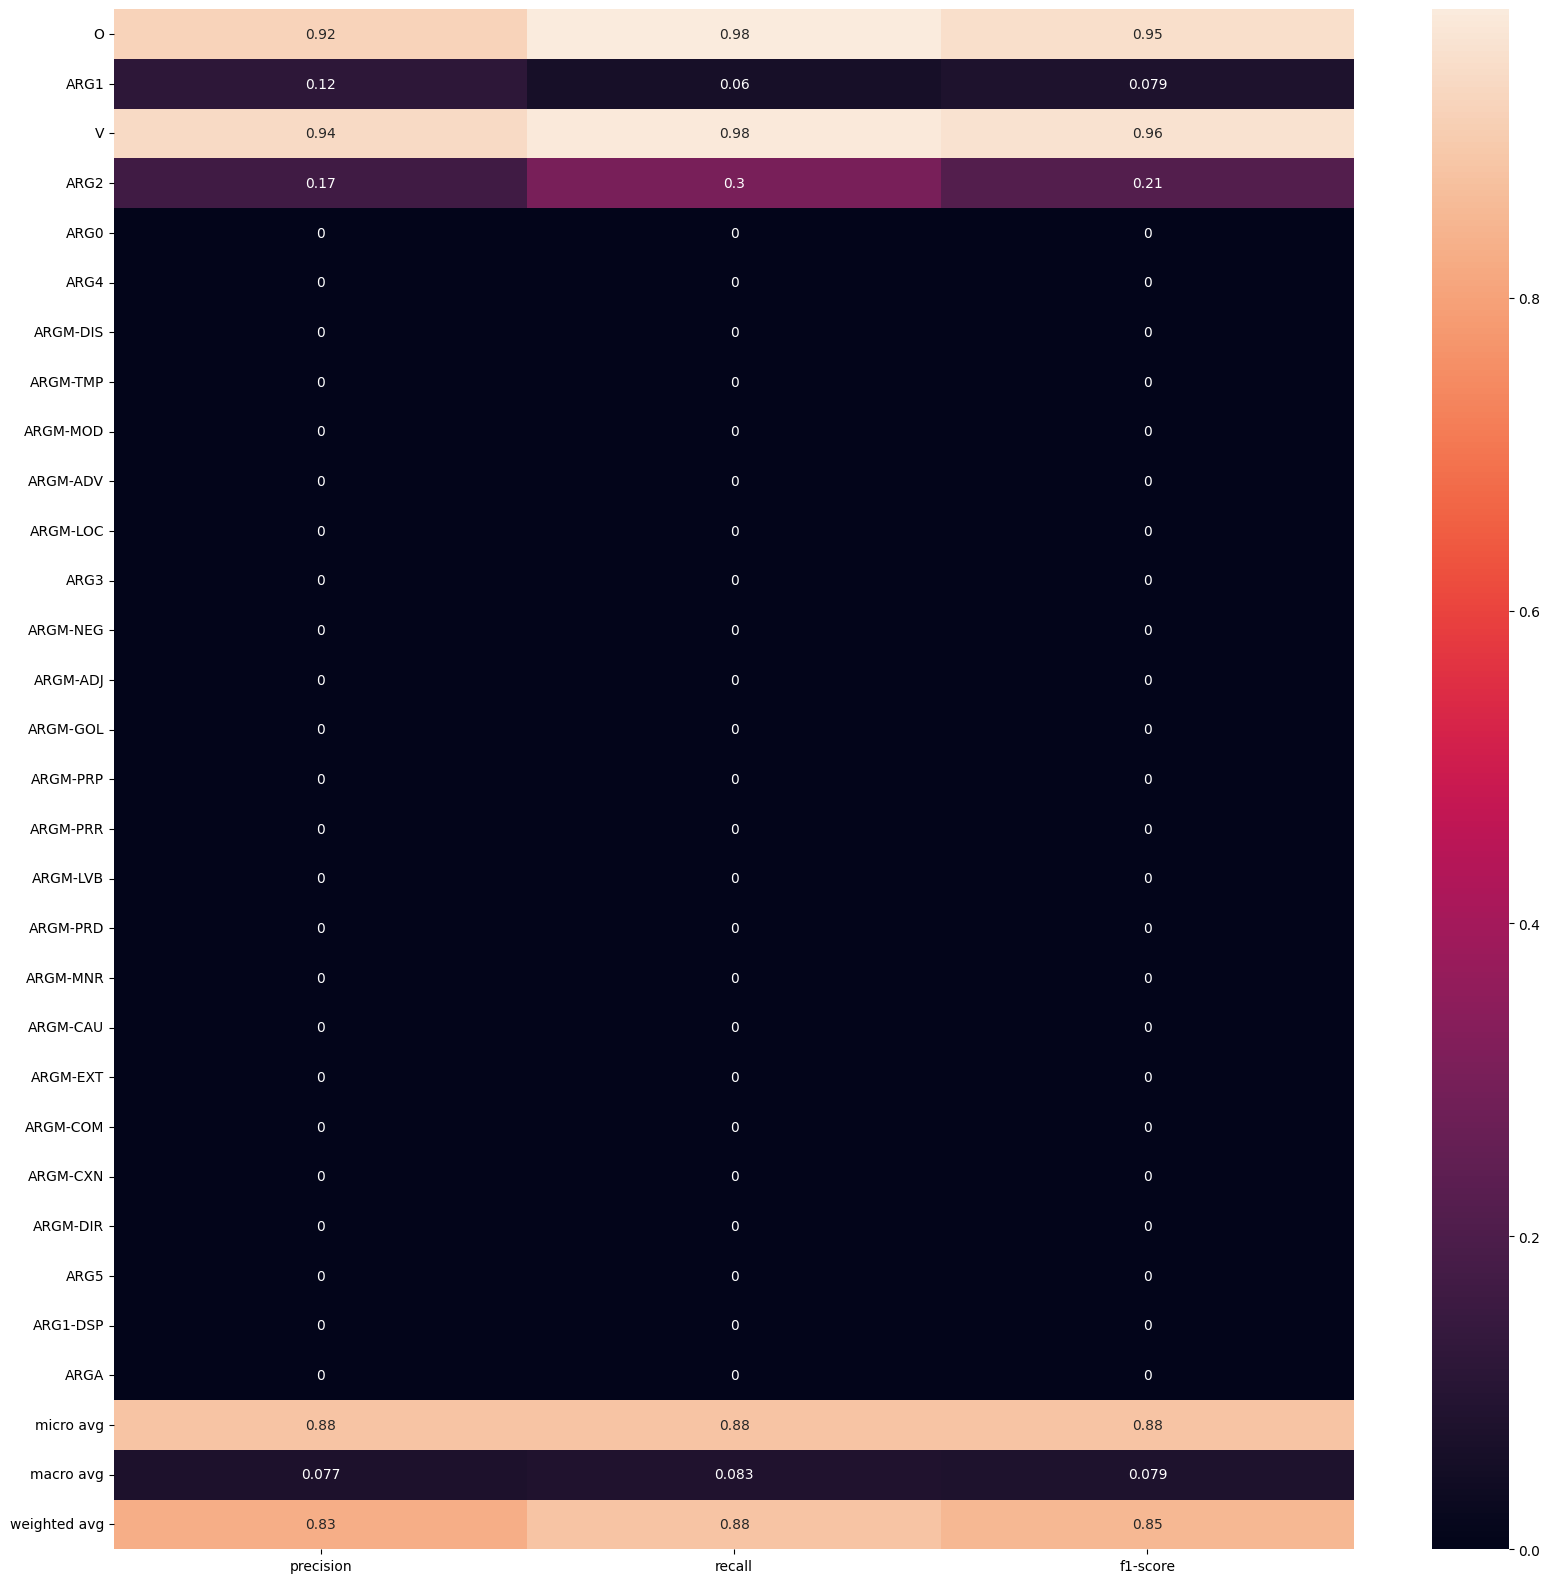

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = [20, 20]

df = pd.read_csv(f'{MODEL_NAME}.csv', index_col=0)
sns.heatmap(df.iloc[:-1, :].T, annot=True)

Now lets look at the count of appearances of each label in the test set. From the almost 100K instances of tokens, about $90%$ is not an argument. Additionally, we can see that many appear less than 100 times. Makes sense that `ARGA` was not predicted since it is basically an outlier.


In [36]:
df['label'].value_counts()

label
O           91733
ARG1         3345
ARG0         1803
ARG2         1137
ARGM-TMP      545
ARGM-ADV      497
ARGM-MOD      442
ARGM-ADJ      229
ARGM-LOC      217
ARGM-NEG      216
ARGM-DIS      182
ARGM-MNR      156
ARGM-EXT      105
ARG3           76
ARGM-PRP       75
ARGM-PRR       69
ARGM-LVB       69
ARG4           56
ARGM-DIR       48
ARGM-CAU       46
ARGM-PRD       44
ARGM-GOL       24
ARGM-CXN       17
ARGM-COM       13
ARG1-DSP        5
ARGA            2
ARG5            1
Name: count, dtype: int64

# 4 Advanced model
Our advanced model is based on NegBERT .  NegBERT uses an annotation schema where certain groups of words are anotated of the labels with the aim of incorporating more information about *negation cues* into the model. According to the authors, this would in turn allow for better cue detection and span detection. We are trying to achieve something similar in the baseline model by appending the predicate at the end, however we do not use a MLP as an additionaly head of the output of the model. However, we will add more information to the input adding the base form of the predicate after the baseline. Thus resulting in `[CLS] sent [SEP] pred pred_base [SEP]` where `pred_base` would be the lemma of the predicate and the classification by PropBank.

Given the previous situation where the model is overfitting and not generalizing correcly, we decide to give more information to the model about the predicate. Instead of using an additional token like NegBERT, we just make our input longer with more predicate information.

To do this we only need to modify our existing utility function for creating the tokenized dataset and add some more steps to it. With that, we just change the following

In [69]:
row = ds[0]

tok_base = tokenizer(row['token'], is_split_into_words=True)
tok_pred_word = tokenizer(row['predicate_token'], is_split_into_words=True)
tok_pred_base = tokenizer(row['predicate'], is_split_into_words=True)




tok_in = tokenizer(row['token'], [row['predicate_token'][0], row['predicate'][0]], is_split_into_words=True)
tokenizer.convert_ids_to_tokens(tok_in['input_ids'])

['[CLS]',
 'four',
 'months',
 'later',
 ',',
 'we',
 'were',
 'married',
 '.',
 '[SEP]',
 'were',
 'be',
 '.',
 '03',
 '[SEP]']

We see this simple change already gives us the desire results. We proceed to test it.

In [32]:
from utils import tokenize_and_align_labels_2
tokenized_datasets_2 = ds.map(lambda x: tokenize_and_align_labels_2(tokenizer, x))

Map: 100%|██████████| 4799/4799 [00:03<00:00, 1488.95 examples/s]


We can reuse the training arguments from before, we will just reset them.

In [ ]:

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    push_to_hub=False,
)

model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_list))

data_collator = DataCollatorForTokenClassification(tokenizer)


Now we define a new trainer and make a copy from the dataset that we already used and proceed to training

In [27]:

from utils import compute_metrics
MODEL_NAME = 'bert_advanced_model_train'
td_2 = tokenized_datasets_2.remove_columns(ds.column_names)
trainer_2 = Trainer(
    model,
    args,
    train_dataset=td_2,
    eval_dataset=td_2,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=lambda x: compute_metrics(x, label_list),
)

trainer_2.train()
trainer_2.save_model(MODEL_NAME)


NameError: name 'tokenized_datasets_2' is not defined

# 4.1 Model results
 

Same as before, we load the `tokenizer` from the trained model

In [ ]:

from transformers import AutoTokenizer
from utils import tokenize_and_align_labels_2, process_df_into_ds
MODEL_NAME = 'bert_advanced_model_train'
filename = TRAIN_FILE_NAME if MODE == 'train' else TEST_FILE_NAME if MODE == 'test' else DEV_FILE_NAME
ds = process_df_into_ds(filename)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, local_files_only=True)
tokenized_datasets = ds.map(lambda x: tokenize_and_align_labels_2(tokenizer, x))

Here we have in just one cell the same step as with the previous model. Just executing the same code, getting the probabilities, using the maxium and then calculating the scores and putting them on a table.

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report
import os
from itertools import chain

trained_model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, local_files_only=True).to('cpu')

label_list = list(ds.features['label'].feature.names)
with torch.inference_mode():

    tokenized_datasets.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
    input_ids = tokenized_datasets['input_ids']#[:100]#.expand(1, -1)
    attention_mask = tokenized_datasets['attention_mask']#[:100]#.expand(1, -1)
    logits = trained_model(input_ids=input_ids, attention_mask=attention_mask).logits
    predicted_token_class_ids = torch.argmax(logits, dim=2).cpu()


    predictions = predicted_token_class_ids
    labels = tokenized_datasets['labels']#[:100]
    proc_y_true = []
    proc_y_pred = []

    for prediction, label in zip(predictions, labels):
        for p, l in zip(prediction, label):
            if l != -100:
                proc_y_true.append(label_list[l])
                proc_y_pred.append(label_list[p.item()])

    true_labels = proc_y_true
    true_predictions = proc_y_pred 

    cr = classification_report(true_labels, true_predictions, labels=label_list, zero_division=0, output_dict=True)
    df = pd.DataFrame.from_dict(cr)
    df.to_csv(f'{MODEL_NAME}.csv')

By looking at the plot below we can see that the overall averages both in terms of **weighted** and **macro** averages are worse than before. That will be reflected in the individual cells. Note that in the Figure, the *precision* for `ARGM-TMP` and `ARGM-ADV` is higher than with the baseline model. Consequently, the *recall* scores are much lower. Additionally `ARGM-CAU` no longer has any predictions and the average **macro** for *F1* is lower than the baseline.

<Axes: >

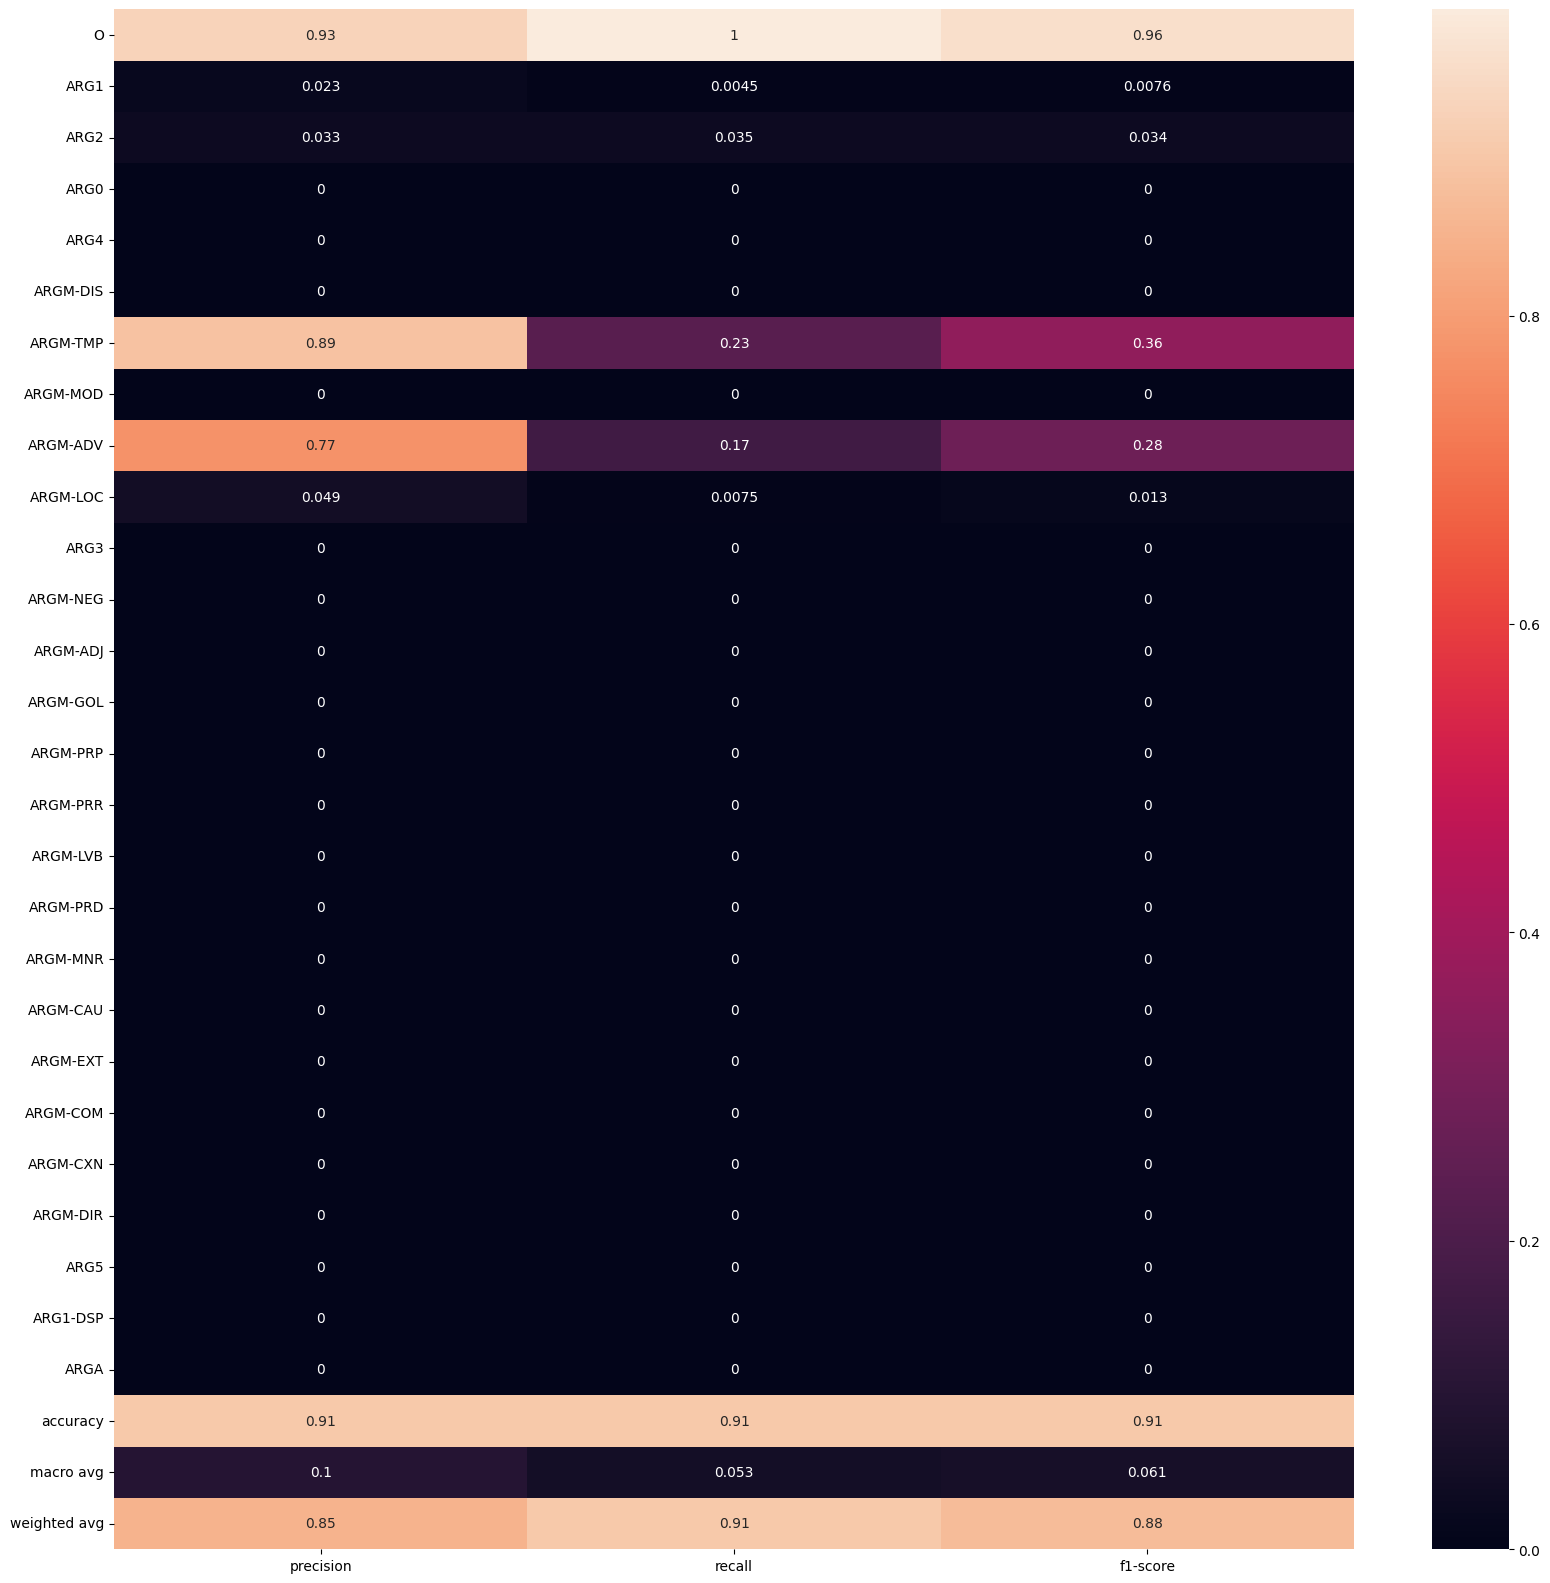

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = [20, 20]
df = pd.read_csv(f'{MODEL_NAME}.csv', index_col=0)
sns.heatmap(df.iloc[:-1, :].T, annot=True)

# 5 Discussion and Conclusions

We implemeted two versions of the `distilBERT` model, a distilled version of `BERT` that trains and infers faster while retaining a $97%$ of performance. We preprocessed the `PropBank` dataset for english in `CONLL-U` format to feed the training to the models. Our first model is a baseline comparison point of `BERT`, using the *question/answer* tokenization schema where the *question* is the sentence and *answer* is the predicate of the sentence. While performing relatively well on the training set, the test set performance proved to be very low on the task of argument classification. The next model, a similar version but that also encoded the lemmatized version of the predicate and an indicator number according to meaning in the *answer* part of the tokenization schema performed somewhat similarly. It showed very good indentification scores but poor classification power in many arguments.

As we saw in the previous section, the distribution over the test dataset of the arguments is very different from the training set. For this, we believe the model was not able to correctly capture the required information of the training data to generalize and thus it does poorly and the classification task. While it does perform very well at identifyin if a token is an argument or not, we believe that there is further work to do on this matter. Providing the input with more argument information would be a way to augment the information the model has about arguments. Also, experimenting with hyperparameter tunning or just chaning batch sizes and learning rate might influence the output. As the model seems to be overfitting, maybe an intermediate model along the training generalizes better. While testing on the development set we found that a model training on that small set has better classification scores of `ARG0`, `ARG1` and `ARG2`.